In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2025-11-22 08:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [          <=>       ]  22.62M  9.68MB/s    in 2.3s    

2025-11-22 08:06:34 (9.68 MB/s) - ‘Online Retail.xlsx’ saved [23715344]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime as dt

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ Kütüphaneler başarıyla yüklendi!")

# 2. VERİYİ YÜKLE
print("\n📁 VERİ YÜKLENİYOR...")
df = pd.read_excel('Online Retail.xlsx')
print("✅ Veri başarıyla yüklendi!")

✅ Kütüphaneler başarıyla yüklendi!

📁 VERİ YÜKLENİYOR...
✅ Veri başarıyla yüklendi!


In [3]:
print("🎯 VERİ SETİ BİLGİLERİ")
print("=" * 50)
print(f"📊 Veri seti boyutu: {df.shape}")
print(f"📈 Satır sayısı: {df.shape[0]:,}")
print(f"📉 Sütun sayısı: {df.shape[1]}")

print("\n📝 İLK 5 KAYIT:")
display(df.head())

print("\n📋 SÜTUN İSİMLERİ:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print("\nℹ️ VERİ TİPLERİ:")
print(df.dtypes)

🎯 VERİ SETİ BİLGİLERİ
📊 Veri seti boyutu: (541909, 8)
📈 Satır sayısı: 541,909
📉 Sütun sayısı: 8

📝 İLK 5 KAYIT:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



📋 SÜTUN İSİMLERİ:
1. InvoiceNo
2. StockCode
3. Description
4. Quantity
5. InvoiceDate
6. UnitPrice
7. CustomerID
8. Country

ℹ️ VERİ TİPLERİ:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [4]:
# --- 2. Temel Veri Temizliği ---
print("\n🧹 Temel temizlik işlemleri başlıyor...")

# Negatif Miktar (Quantity) ve İptal Edilen Siparişlerin Kaldırılması
# İade olan (InvoiceNo 'C' ile başlayan) ve diğer negatif miktarlı girişler kaldırılır.
df_clean = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df_clean = df_clean[df_clean['Quantity'] > 0]

# Fiyatı Sıfır (UnitPrice) Olan Kayıtların Kaldırılması
# Fiyatı olmayan ürünler gelire katkı sağlamaz ve analizde gürültü yaratabilir.
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Eksik Müşteri ID (CustomerID) ve Açıklama (Description) Olanların Kaldırılması
# Müşteri bazlı analiz için CustomerID, ürün analizi için Description zorunludur.
df_clean.dropna(subset=['CustomerID', 'Description'], inplace=True)

# CustomerID Veri Tipini Düzeltme
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

print(f"Temel temizlik sonrası kayıt sayısı: {df_clean.shape[0]:,}")


# --- 3. Toplam Fiyat Sütunu Oluşturma ---
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


# --- 4. Aykırı Değerleri Tespit ve Temizleme (IQR Yöntemi) ---
print("\n📉 Aykırı değer (outlier) temizliği başlıyor...")

def remove_outliers(df, column_name):
    """
    Verilen bir sütundaki aykırı değerleri IQR yöntemine göre temizler.
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    original_count = df.shape[0]
    df_out = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    removed_count = original_count - df_out.shape[0]

    print(f"'{column_name}' sütunundan {removed_count:,} aykırı değer kaldırıldı. (Alt limit: {lower_bound:.2f}, Üst limit: {upper_bound:.2f})")

    return df_out

# Quantity ve TotalPrice sütunlarındaki aykırı değerleri temizleyelim
df_no_outliers = remove_outliers(df_clean, 'Quantity')
df_no_outliers = remove_outliers(df_no_outliers, 'TotalPrice')


# --- 5. Sonuçların Gösterilmesi ---
print("\n✨ Tüm temizlik ve aykırı değer işlemleri tamamlandı!")
print(f"Nihai kayıt sayısı: {df_no_outliers.shape[0]:,}")
print(f"Toplam çıkarılan kayıt sayısı: {df.shape[0] - df_no_outliers.shape[0]:,}")

print("\nTemizlenmiş Veri Setinden İlk 5 Kayıt:")
display(df_no_outliers.head())

print("\nTemizlenmiş Veri Setinin İstatistiksel Özeti:")
display(df_no_outliers.describe())
df_clean= df_no_outliers


🧹 Temel temizlik işlemleri başlıyor...
Temel temizlik sonrası kayıt sayısı: 397,884

📉 Aykırı değer (outlier) temizliği başlıyor...
'Quantity' sütunundan 25,647 aykırı değer kaldırıldı. (Alt limit: -13.00, Üst limit: 27.00)
'TotalPrice' sütunundan 19,152 aykırı değer kaldırıldı. (Alt limit: -16.05, Üst limit: 37.95)

✨ Tüm temizlik ve aykırı değer işlemleri tamamlandı!
Nihai kayıt sayısı: 353,085
Toplam çıkarılan kayıt sayısı: 188,824

Temizlenmiş Veri Setinden İlk 5 Kayıt:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34



Temizlenmiş Veri Setinin İstatistiksel Özeti:


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,353085.000000,353085,353085.000000,353085.000000,353085.000000
mean,6.646972,2011-07-11 16:22:54.323633152,2.767055,15330.466633,11.360738
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000,0.001000
25%,2.000000,2011-04-07 12:10:00,1.250000,14009.000000,4.150000
50%,4.000000,2011-08-01 13:31:00,1.690000,15249.000000,10.080000
75%,12.000000,2011-10-21 14:41:00,3.750000,16830.000000,16.600000
max,27.000000,2011-12-09 12:50:00,37.500000,18287.000000,37.950000
std,6.391320,NaN,2.761870,1707.559613,8.354469


In [5]:
# 5. TEMEL İSTATİSTİKLER
print("\n💰 TEMEL İSTATİSTİKLER")
print("=" * 40)

# TotalPrice hesapla
df_no_outliers['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"💰 Toplam Gelir: ${df_clean['TotalPrice'].sum():,.2f}")
print(f"👥 Toplam Müşteri: {df_clean['CustomerID'].nunique():,}")
print(f"📦 Toplam Ürün: {df_clean['StockCode'].nunique():,}")
print(f"🏪 Toplam İşlem: {df_clean['InvoiceNo'].nunique():,}")
print(f"📅 İşlem Tarihi: {df_clean['InvoiceDate'].min().date()} - {df_clean['InvoiceDate'].max().date()}")
df_final = df_clean




💰 TEMEL İSTATİSTİKLER
💰 Toplam Gelir: $4,011,306.07
👥 Toplam Müşteri: 4,173
📦 Toplam Ürün: 3,625
🏪 Toplam İşlem: 16,532
📅 İşlem Tarihi: 2010-12-01 - 2011-12-09



📊 GÖRSELLEŞTİRMELER


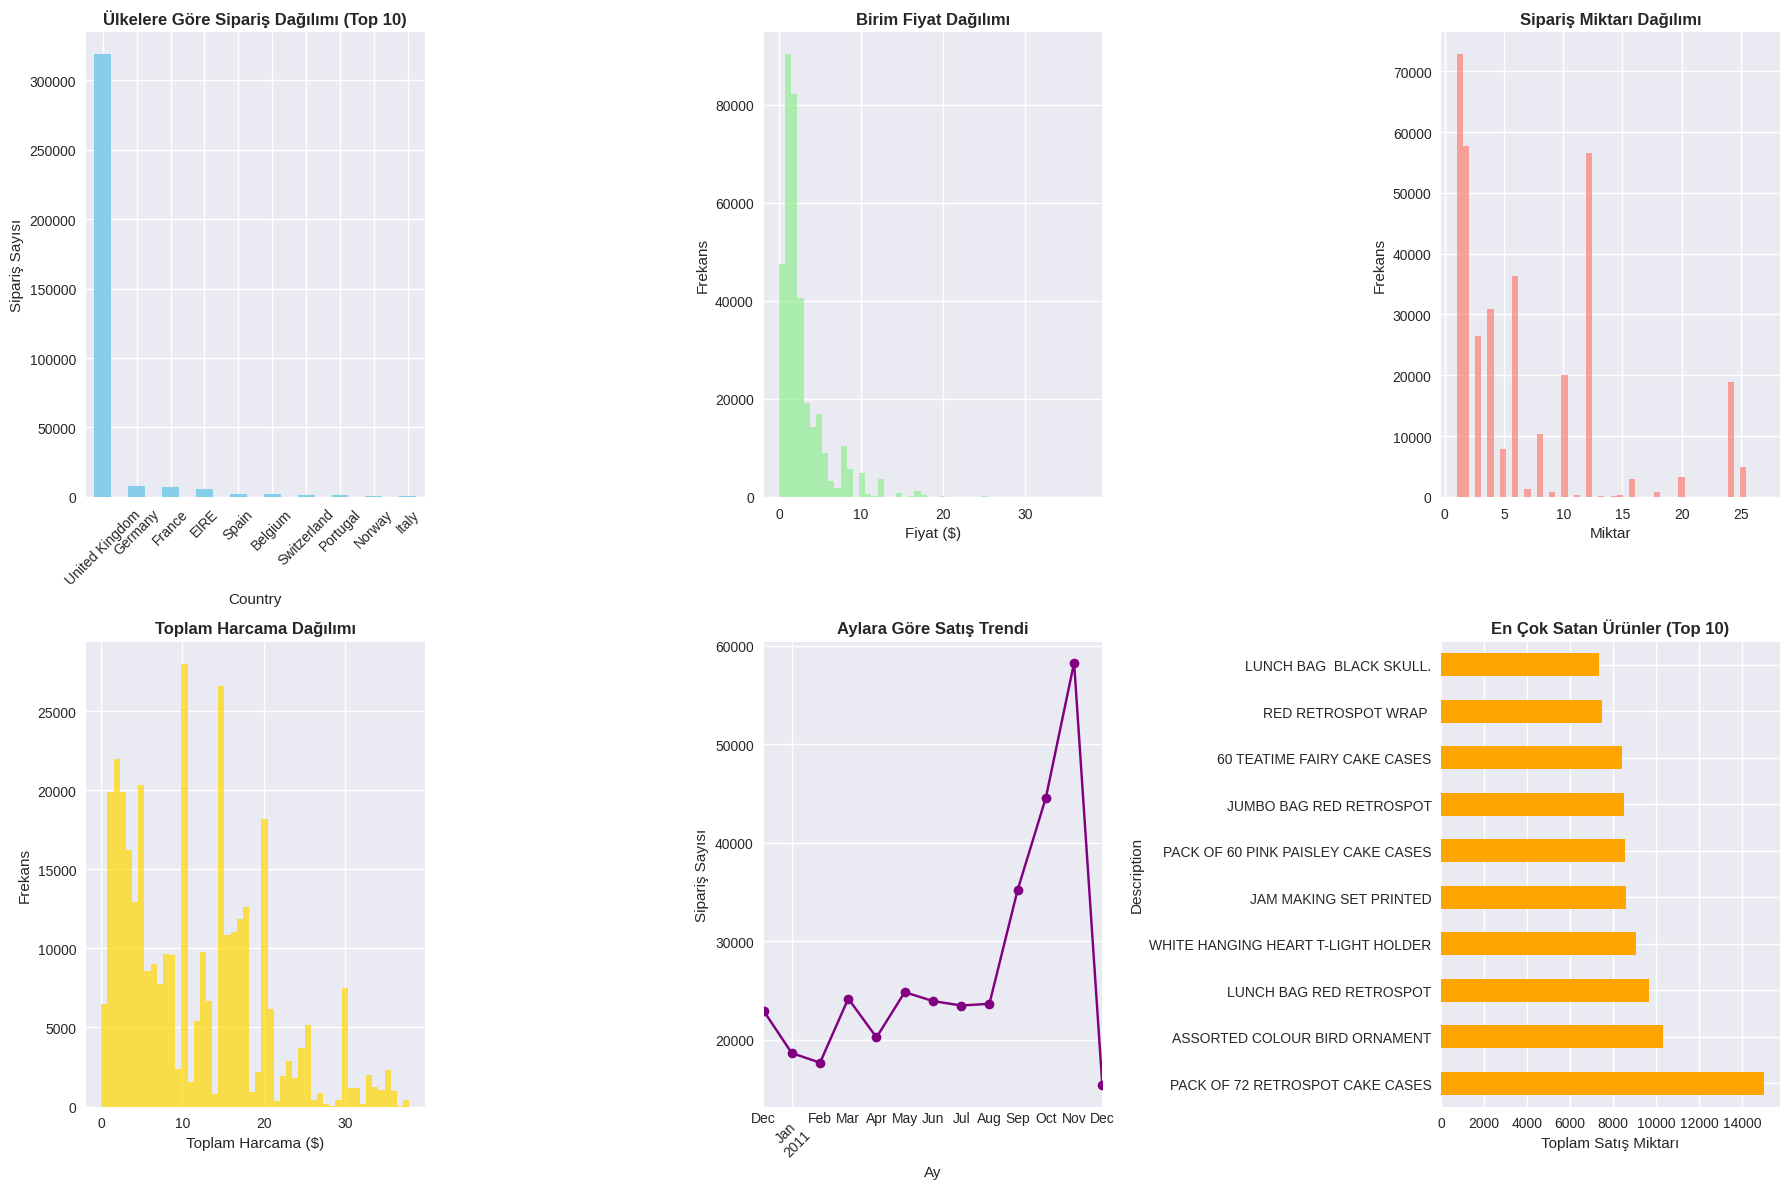

In [6]:
# 6. GÖRSELLEŞTİRMELER
print("\n📊 GÖRSELLEŞTİRMELER")
print("=" * 40)

plt.figure(figsize=(18, 12))

# 1. Ülkelere göre dağılım
plt.subplot(2, 3, 1)
country_counts = df_final['Country'].value_counts().head(10)
country_counts.plot(kind='bar', color='skyblue')
plt.title('Ülkelere Göre Sipariş Dağılımı (Top 10)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Sipariş Sayısı')

# 2. Birim fiyat dağılımı
plt.subplot(2, 3, 2)
df_final['UnitPrice'].hist(bins=50, color='lightgreen', alpha=0.7)
plt.title('Birim Fiyat Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Fiyat ($)')
plt.ylabel('Frekans')

# 3. Sipariş miktarı dağılımı
plt.subplot(2, 3, 3)
df_final['Quantity'].hist(bins=50, color='salmon', alpha=0.7)
plt.title('Sipariş Miktarı Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Miktar')
plt.ylabel('Frekans')

# 4. Toplam harcama dağılımı
plt.subplot(2, 3, 4)
df_final['TotalPrice'].hist(bins=50, color='gold', alpha=0.7)
plt.title('Toplam Harcama Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Toplam Harcama ($)')
plt.ylabel('Frekans')

# 5. Aylara göre satışlar
plt.subplot(2, 3, 5)
df_final['InvoiceDate'].dt.to_period('M').value_counts().sort_index().plot(kind='line', color='purple', marker='o')
plt.title('Aylara Göre Satış Trendi', fontsize=12, fontweight='bold')
plt.xlabel('Ay')
plt.ylabel('Sipariş Sayısı')
plt.xticks(rotation=45)

# 6. En çok satan ürünler (top 10)
plt.subplot(2, 3, 6)
top_products = df_final.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', color='orange')
plt.title('En Çok Satan Ürünler (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Toplam Satış Miktarı')

plt.tight_layout()
plt.show()

In [7]:
# 7. EK ANALİZLER
print("\n📈 EK ANALİZLER")
print("=" * 40)

# En değerli müşteriler
top_customers = df_final.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("\n🏆 EN DEĞERLİ 10 MÜŞTERİ:")
for i, (cust_id, revenue) in enumerate(top_customers.items(), 1):
    print(f"{i}. Müşteri {cust_id}: ${revenue:,.2f}")

# Ortalama değerler
avg_order_value = df_final['TotalPrice'].mean()
avg_quantity = df_final['Quantity'].mean()
print(f"\n📊 Ortalama Sipariş Değeri: ${avg_order_value:.2f}")
print(f"📦 Ortalama Sipariş Miktarı: {avg_quantity:.1f}")


📈 EK ANALİZLER

🏆 EN DEĞERLİ 10 MÜŞTERİ:
1. Müşteri 14911: $81,296.51
2. Müşteri 14096: $40,937.96
3. Müşteri 17841: $35,155.12
4. Müşteri 13089: $26,145.21
5. Müşteri 12748: $22,576.40
6. Müşteri 14298: $17,107.39
7. Müşteri 13081: $13,750.58
8. Müşteri 15039: $13,133.27
9. Müşteri 14156: $12,542.03
10. Müşteri 15311: $11,915.13

📊 Ortalama Sipariş Değeri: $11.36
📦 Ortalama Sipariş Miktarı: 6.6


In [8]:
# 8. RFM ANALİZİ HAZIRLIĞI
print("🎯 RFM ANALİZİ BAŞLIYOR...")
print("=" * 50)

# Son tarihi belirle (en son işlem tarihinden 1 gün sonrası)
snapshot_date = df_final['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"📅 Analiz tarihi: {snapshot_date.date()}")

# RFM metriklerini hesapla
print("\n📊 RFM METRİKLERİ HESAPLANIYOR...")
rfm = df_final.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency: Son alışverişten bugüne kadar geçen gün
    'InvoiceNo': 'nunique',                                  # Frequency: Toplam sipariş sayısı
    'TotalPrice': 'sum'                                      # Monetary: Toplam harcama
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print(f"✅ RFM tablosu oluşturuldu: {rfm.shape}")

print("\n📈 RFM İSTATİSTİKLERİ:")
print(rfm.describe())

🎯 RFM ANALİZİ BAŞLIYOR...
📅 Analiz tarihi: 2011-12-10

📊 RFM METRİKLERİ HESAPLANIYOR...
✅ RFM tablosu oluşturuldu: (4173, 3)

📈 RFM İSTATİSTİKLERİ:
           Recency    Frequency      Monetary
count  4173.000000  4173.000000   4173.000000
mean     93.053199     3.961658    961.252354
std     100.034949     6.906405   2025.871371
min       1.000000     1.000000      1.700000
25%      18.000000     1.000000    197.630000
50%      51.000000     2.000000    467.510000
75%     145.000000     4.000000   1081.740000
max     374.000000   197.000000  81296.510000


In [9]:
# 9. RFM VERİSİNE İLK BAKIŞ
print("🔍 RFM VERİSİ İNCELENİYOR...")
print("=" * 40)

print("İlk 10 müşterinin RFM değerleri:")
display(rfm.head(10))

print(f"\nToplam müşteri sayısı: {len(rfm):,}")

# Negatif monetary değerleri kontrol et (iade olabilir)
negative_monetary = rfm[rfm['Monetary'] < 0]
print(f"⚠️  Negatif harcaması olan müşteri sayısı: {len(negative_monetary)}")

# Monetary değeri 0'dan büyük olanları seç (segmentasyon için)
rfm_positive = rfm[rfm['Monetary'] > 0]
print(f"✅ Pozitif harcaması olan müşteri sayısı: {len(rfm_positive):,}")

🔍 RFM VERİSİ İNCELENİYOR...
İlk 10 müşterinin RFM değerleri:


,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,2823.17
12348,249,3,90.20
12349,19,1,1105.40
12350,310,1,294.40
12352,36,7,1347.49
12353,204,1,49.20
12354,232,1,876.28
12355,214,1,224.80
12356,23,3,549.41



Toplam müşteri sayısı: 4,173
⚠️  Negatif harcaması olan müşteri sayısı: 0
✅ Pozitif harcaması olan müşteri sayısı: 4,173



📊 RFM DAĞILIM GRAFİKLERİ


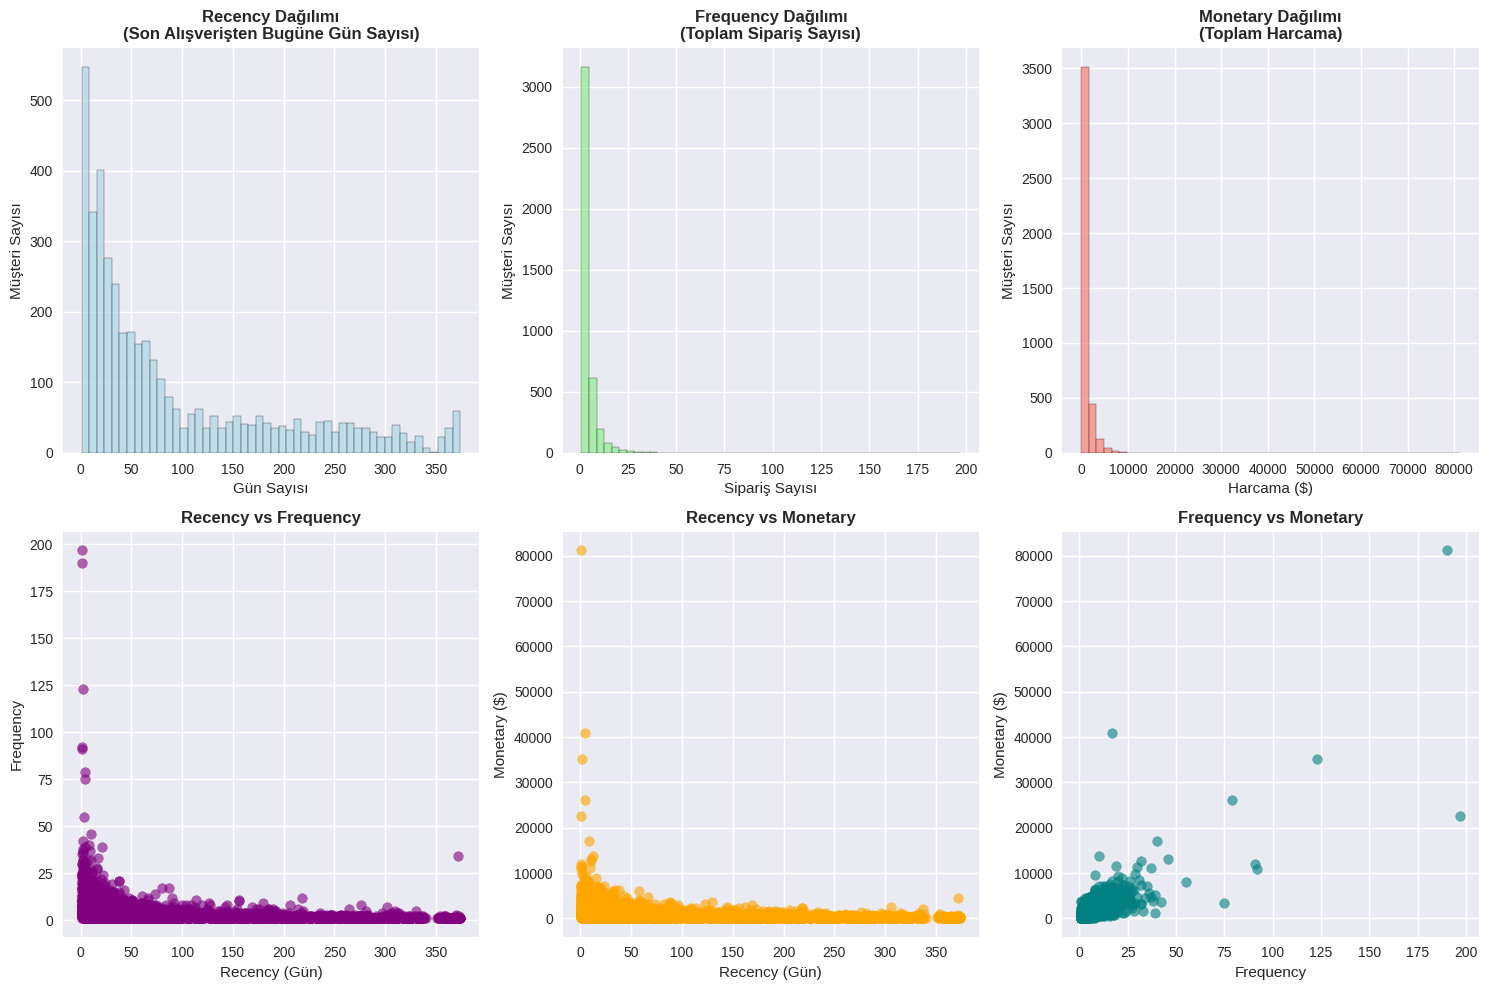

In [10]:
# 10. RFM DAĞILIM GÖRSELLEŞTİRMELERİ
print("\n📊 RFM DAĞILIM GRAFİKLERİ")
print("=" * 50)

plt.figure(figsize=(15, 10))

# Recency dağılımı
plt.subplot(2, 3, 1)
plt.hist(rfm_positive['Recency'], bins=50, color='lightblue', alpha=0.7, edgecolor='black')
plt.title('Recency Dağılımı\n(Son Alışverişten Bugüne Gün Sayısı)', fontweight='bold')
plt.xlabel('Gün Sayısı')
plt.ylabel('Müşteri Sayısı')

# Frequency dağılımı
plt.subplot(2, 3, 2)
plt.hist(rfm_positive['Frequency'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Frequency Dağılımı\n(Toplam Sipariş Sayısı)', fontweight='bold')
plt.xlabel('Sipariş Sayısı')
plt.ylabel('Müşteri Sayısı')

# Monetary dağılımı
plt.subplot(2, 3, 3)
plt.hist(rfm_positive['Monetary'], bins=50, color='salmon', alpha=0.7, edgecolor='black')
plt.title('Monetary Dağılımı\n(Toplam Harcama)', fontweight='bold')
plt.xlabel('Harcama ($)')
plt.ylabel('Müşteri Sayısı')

# Recency - Frequency scatter
plt.subplot(2, 3, 4)
plt.scatter(rfm_positive['Recency'], rfm_positive['Frequency'], alpha=0.6, color='purple')
plt.title('Recency vs Frequency', fontweight='bold')
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency')

# Recency - Monetary scatter
plt.subplot(2, 3, 5)
plt.scatter(rfm_positive['Recency'], rfm_positive['Monetary'], alpha=0.6, color='orange')
plt.title('Recency vs Monetary', fontweight='bold')
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary ($)')

# Frequency - Monetary scatter
plt.subplot(2, 3, 6)
plt.scatter(rfm_positive['Frequency'], rfm_positive['Monetary'], alpha=0.6, color='teal')
plt.title('Frequency vs Monetary', fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')

plt.tight_layout()
plt.show()


📈 RFM KORELASYON MATRİSİ
Korelasyon Matrisi:
            Recency  Frequency  Monetary
Recency    1.000000  -0.260346 -0.230047
Frequency -0.260346   1.000000  0.789274
Monetary  -0.230047   0.789274  1.000000


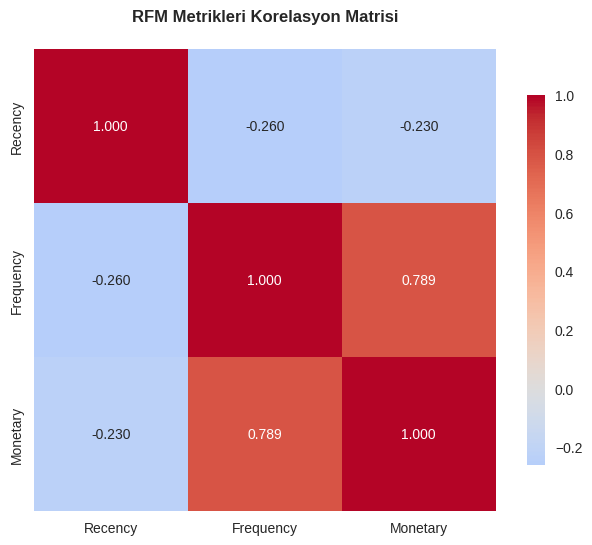


💡 KORELASYON YORUMU:
• Frequency - Monetary: 0.789
  → Sık alışveriş yapan müşteriler daha fazla harcıyor!
• Recency - Frequency: -0.260
  → Recency ile frequency arasında zayıf ilişki var.


In [11]:
# 11. KORELASYON ANALİZİ
print("\n📈 RFM KORELASYON MATRİSİ")
print("=" * 40)

correlation_matrix = rfm_positive.corr()
print("Korelasyon Matrisi:")
print(correlation_matrix)

# Korelasyon heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('RFM Metrikleri Korelasyon Matrisi', fontweight='bold', pad=20)
plt.show()

# Korelasyon yorumu
print("\n💡 KORELASYON YORUMU:")
print(f"• Frequency - Monetary: {correlation_matrix.loc['Frequency', 'Monetary']:.3f}")
if correlation_matrix.loc['Frequency', 'Monetary'] > 0.5:
    print("  → Sık alışveriş yapan müşteriler daha fazla harcıyor!")
else:
    print("  → Sıklık ile harcama arasında orta düzeyde ilişki var.")

print(f"• Recency - Frequency: {correlation_matrix.loc['Recency', 'Frequency']:.3f}")
if correlation_matrix.loc['Recency', 'Frequency'] < -0.3:
    print("  → Yeni alışveriş yapan müşteriler daha sık alışveriş yapıyor!")
else:
    print("  → Recency ile frequency arasında zayıf ilişki var.")

In [12]:
# 14. STANDARDİZASYON İŞLEMİ
print("\n⚙️ STANDARDİZASYON İŞLEMİ")
print("=" * 50)

# StandardScaler uygula
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_positive)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_positive.index, columns=rfm_positive.columns)

print("✅ Veri standardize edildi!")
print("\n📊 Standardize edilmiş veri istatistikleri:")
print(rfm_scaled.describe())

# Standardizasyon sonrası kontrol
print(f"\n🔍 Standardizasyon sonrası:")
print(f"• Ortalamalar: {rfm_scaled.mean().round(3).tolist()}")
print(f"• Standart sapmalar: {rfm_scaled.std().round(3).tolist()}")
print("→ Tüm değişkenler ~0 ortalamalı ve ~1 standart sapmalı!")


⚙️ STANDARDİZASYON İŞLEMİ
✅ Veri standardize edildi!

📊 Standardize edilmiş veri istatistikleri:
            Recency     Frequency      Monetary
count  4.173000e+03  4.173000e+03  4.173000e+03
mean   6.214908e-17  1.702714e-17 -6.810858e-18
std    1.000120e+00  1.000120e+00  1.000120e+00
min   -9.203207e-01 -4.288791e-01 -4.737060e-01
25%   -7.503597e-01 -4.288791e-01 -3.769804e-01
50%   -4.204355e-01 -2.840687e-01 -2.437477e-01
75%    5.193488e-01  5.552283e-03  5.948161e-02
max    2.808823e+00  2.795397e+01  3.965942e+01

🔍 Standardizasyon sonrası:
• Ortalamalar: [0.0, 0.0, -0.0]
• Standart sapmalar: [1.0, 1.0, 1.0]
→ Tüm değişkenler ~0 ortalamalı ve ~1 standart sapmalı!



🎯 OPTİMUM KÜME SAYISI ANALİZİ
Elbow yöntemi uygulanıyor...


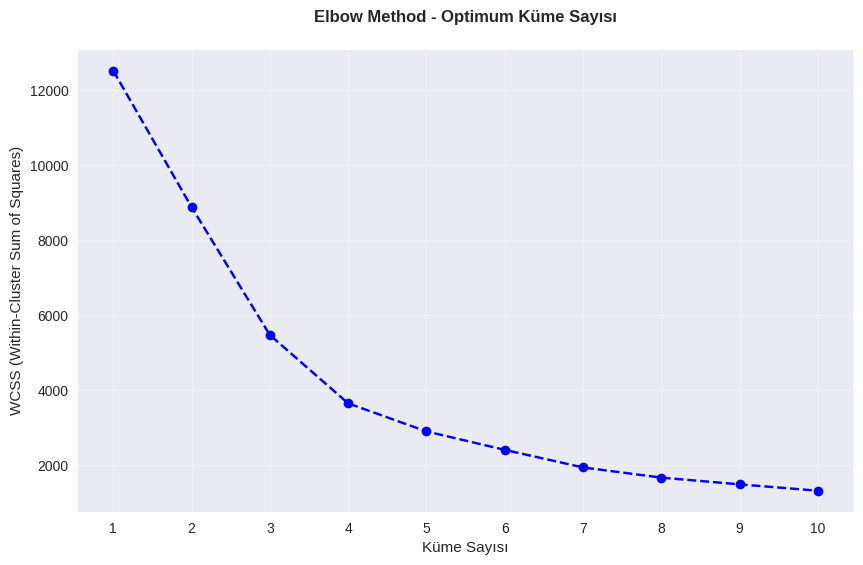

✅ Elbow grafiği oluşturuldu!


In [13]:
# 15. OPTİMUM KÜME SAYISINI BELİRLEME
print("\n🎯 OPTİMUM KÜME SAYISI ANALİZİ")
print("=" * 50)

# Elbow yöntemi ile optimum küme sayısını bul
print("Elbow yöntemi uygulanıyor...")
wcss = []
range_values = range(1, 11)
for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled) # rfm_scaled'i kullandığınızdan emin olun
    wcss.append(kmeans.inertia_)

# Elbow grafiği
plt.figure(figsize=(10, 6))
plt.plot(range_values, wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method - Optimum Küme Sayısı', fontweight='bold', pad=20)
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range_values)
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Elbow grafiği oluşturuldu!")

In [14]:
# Elbow noktasını belirleme
wcss_diff = [wcss[i-1] - wcss[i] for i in range(1, len(wcss))]
elbow_point = wcss_diff.index(max(wcss_diff)) + 2  # +2 because we start from 2 clusters

print(f"\n💡 TAVSİYE EDİLEN KÜME SAYISI: {elbow_point}")
print("""
📝 YORUM:
• Grafikte 'dirsek' noktasını bulmaya çalışıyoruz
• Bu noktadan sonra ek kümeler çok az ek değer katıyor
• Genellikle 3-5 küme arası ideal oluyor
""")


💡 TAVSİYE EDİLEN KÜME SAYISI: 2

📝 YORUM:
• Grafikte 'dirsek' noktasını bulmaya çalışıyoruz
• Bu noktadan sonra ek kümeler çok az ek değer katıyor
• Genellikle 3-5 küme arası ideal oluyor



In [15]:
# 16. K-MEANS KÜMELEME UYGULAMA
print("\n🎯 K-MEANS KÜMELEME BAŞLIYOR...")
print("=" * 50)

# 4 küme ile model oluşturalım (elbow noktası)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Küme etiketlerini ekle
rfm_final = rfm_positive.copy()
rfm_final['Cluster'] = kmeans.labels_
rfm_final['Cluster'] = rfm_final['Cluster'].astype(str)

print("✅ Kümeleme tamamlandı!")
print(f"📊 Küme dağılımı:")
print(rfm_final['Cluster'].value_counts().sort_index())


🎯 K-MEANS KÜMELEME BAŞLIYOR...
✅ Kümeleme tamamlandı!
📊 Küme dağılımı:
Cluster
0    2793
1       5
2    1039
3     336
Name: count, dtype: int64


In [16]:
# 17. KÜME ANALİZİ
print("\n📊 KÜME İSTATİSTİKLERİ")
print("=" * 50)

# Küme bazlı istatistikler
cluster_summary = rfm_final.groupby('Cluster').agg({
    'Recency': ['count', 'mean', 'std'],
    'Frequency': ['mean', 'std', 'min', 'max'],
    'Monetary': ['mean', 'std', 'min', 'max']
}).round(2)

print("Küme Özet Tablosu:")
display(cluster_summary)

# Daha okunabilir bir özet
print("\n🎯 KÜME PROFİLLERİ")
print("=" * 40)

for cluster in sorted(rfm_final['Cluster'].unique()):
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]

    print(f"\n📦 **KÜME {cluster}**")
    print(f"   👥 Müşteri Sayısı: {len(cluster_data):,}")
    print(f"   📅 Ortalama Recency: {cluster_data['Recency'].mean():.1f} gün")
    print(f"   🔄 Ortalama Frequency: {cluster_data['Frequency'].mean():.1f} sipariş")
    print(f"   💰 Ortalama Monetary: ${cluster_data['Monetary'].mean():,.2f}")


📊 KÜME İSTATİSTİKLERİ
Küme Özet Tablosu:


Recency                Frequency                  Monetary            \
          count    mean    std      mean    std min  max      mean       std   
Cluster                                                                        
0          2793   45.21  36.27      3.20   2.27   1   13    762.55    690.62   
1             5    2.40   1.52    121.20  76.03  17  197  41222.24  23546.88   
2          1039  247.54  66.38      1.51   1.03   1   12    308.94    325.60   
3           336   14.37  23.85     16.16  10.06   4   92   4030.92   2212.45   

                             
              min       max  
Cluster                      
0            1.90   4455.80  
1        22576.40  81296.51  
2            1.70   3033.24  
3          580.34  17107.39


🎯 KÜME PROFİLLERİ

📦 **KÜME 0**
   👥 Müşteri Sayısı: 2,793
   📅 Ortalama Recency: 45.2 gün
   🔄 Ortalama Frequency: 3.2 sipariş
   💰 Ortalama Monetary: $762.55

📦 **KÜME 1**
   👥 Müşteri Sayısı: 5
   📅 Ortalama Recency: 2.4 gün
   🔄 Ortalama Frequency: 121.2 sipariş
   💰 Ortalama Monetary: $41,222.24

📦 **KÜME 2**
   👥 Müşteri Sayısı: 1,039
   📅 Ortalama Recency: 247.5 gün
   🔄 Ortalama Frequency: 1.5 sipariş
   💰 Ortalama Monetary: $308.94

📦 **KÜME 3**
   👥 Müşteri Sayısı: 336
   📅 Ortalama Recency: 14.4 gün
   🔄 Ortalama Frequency: 16.2 sipariş
   💰 Ortalama Monetary: $4,030.92



📊 KÜME GÖRSELLEŞTİRMELERİ


/tmp/ipython-input-44729815.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=sorted(rfm_final['Cluster'].unique()))


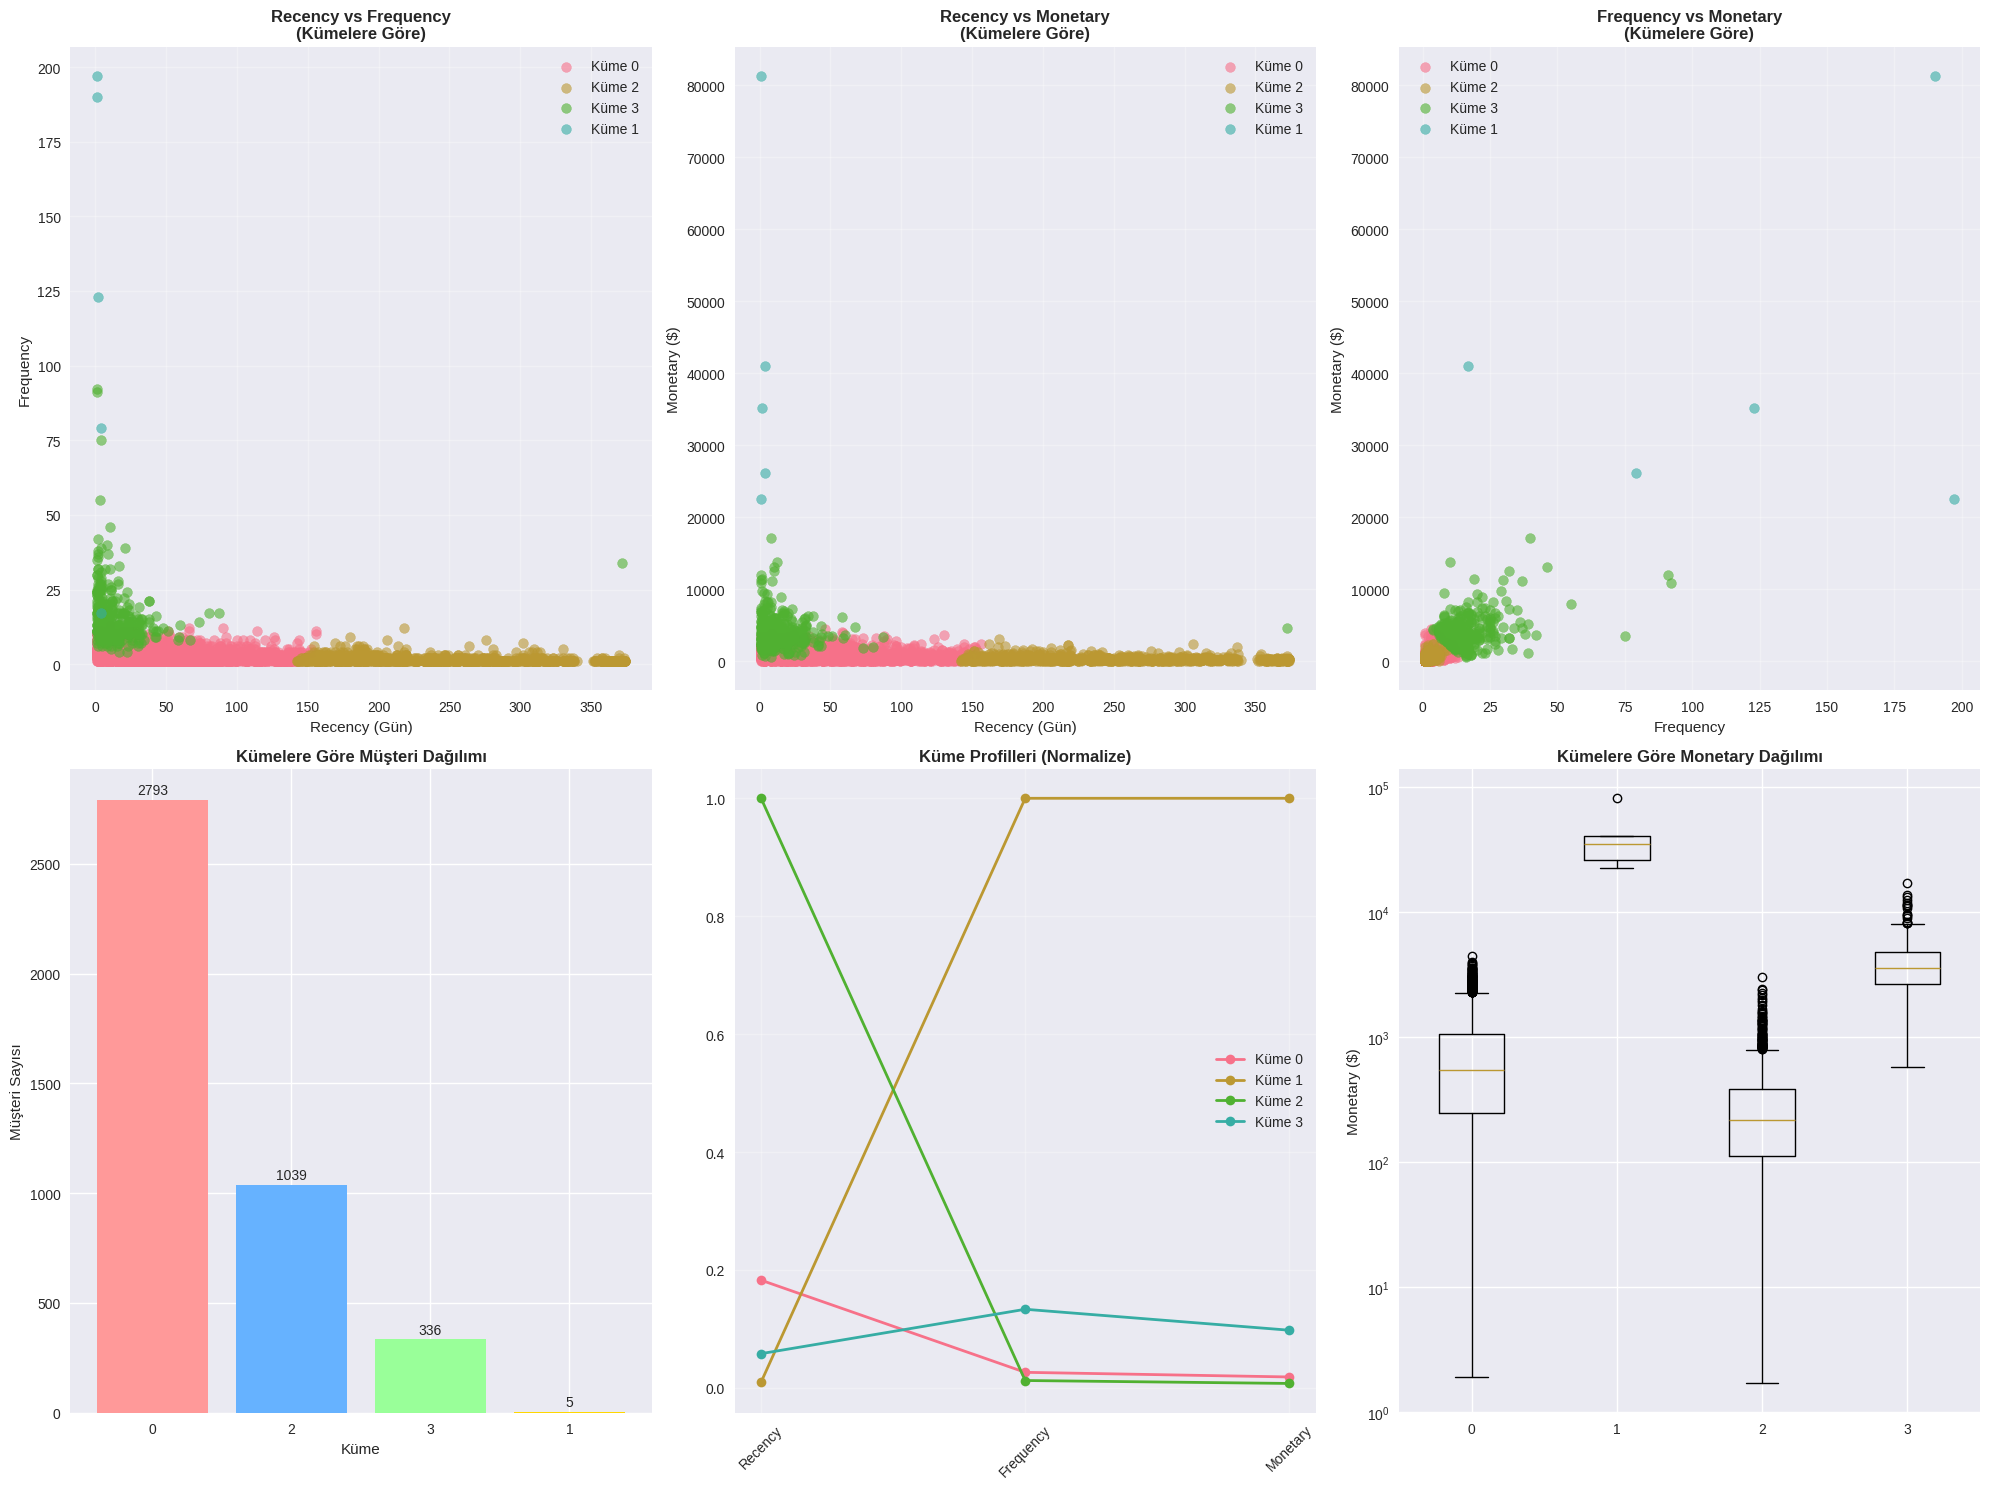

In [17]:
# 18. KÜME GÖRSELLEŞTİRMELERİ
print("\n📊 KÜME GÖRSELLEŞTİRMELERİ")
print("=" * 50)

plt.figure(figsize=(20, 15))

# 1. Recency vs Frequency
plt.subplot(2, 3, 1)
for cluster in rfm_final['Cluster'].unique():
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Frequency'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Recency (Gün)')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Recency vs Monetary
plt.subplot(2, 3, 2)
for cluster in rfm_final['Cluster'].unique():
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Recency (Gün)')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Frequency vs Monetary
plt.subplot(2, 3, 3)
for cluster in rfm_final['Cluster'].unique():
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    plt.scatter(cluster_data['Frequency'], cluster_data['Monetary'],
                label=f'Küme {cluster}', alpha=0.6, s=50)
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')
plt.title('Frequency vs Monetary\n(Kümelere Göre)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Küme dağılımı - Bar chart
plt.subplot(2, 3, 4)
cluster_counts = rfm_final['Cluster'].value_counts()
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700']
plt.bar(cluster_counts.index, cluster_counts.values, color=colors[:len(cluster_counts)])
plt.xlabel('Küme')
plt.ylabel('Müşteri Sayısı')
plt.title('Kümelere Göre Müşteri Dağılımı', fontweight='bold')
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

# 5. Ortalama değerler - Radar chart hazırlığı
plt.subplot(2, 3, 5)
cluster_means = rfm_final.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize et (0-1 arası)
cluster_means_normalized = cluster_means / cluster_means.max()

for cluster in cluster_means_normalized.index:
    values = cluster_means_normalized.loc[cluster].values
    plt.plot(['Recency', 'Frequency', 'Monetary'], values,
             marker='o', label=f'Küme {cluster}', linewidth=2)
plt.title('Küme Profilleri (Normalize)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 6. Monetary dağılımı - Box plot
plt.subplot(2, 3, 6)
box_data = [rfm_final[rfm_final['Cluster'] == cluster]['Monetary'] for cluster in sorted(rfm_final['Cluster'].unique())]
plt.boxplot(box_data, labels=sorted(rfm_final['Cluster'].unique()))
plt.ylabel('Monetary ($)')
plt.title('Kümelere Göre Monetary Dağılımı', fontweight='bold')
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

In [18]:
# 19. KÜME YORUMLARI VE İŞ STRATEJİLERİ
print("\n🎯 KÜME YORUMLARI VE PAZARLAMA STRATEJİLERİ")
print("=" * 60)

# Küme profillerini analiz et
cluster_profiles = {}

for cluster in sorted(rfm_final['Cluster'].unique()):
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]

    recency_mean = cluster_data['Recency'].mean()
    frequency_mean = cluster_data['Frequency'].mean()
    monetary_mean = cluster_data['Monetary'].mean()

    print(f"\n📊 **KÜME {cluster} ANALİZİ**")
    print(f"   Müşteri Sayısı: {len(cluster_data):,}")
    print(f"   Recency: {recency_mean:.1f} gün")
    print(f"   Frequency: {frequency_mean:.1f} sipariş")
    print(f"   Monetary: ${monetary_mean:,.2f}")

    # Küme tipini belirle
    if recency_mean < 50 and frequency_mean > 5 and monetary_mean > 1000:
        profile = "🏆 VIP MÜŞTERİLER"
        strategy = """
        ✅ STRATEJİ:
        • Özel indirimler ve erken erişim
        • Kişisel alışveriş danışmanı
        • Doğum günü hediyeleri
        """
    elif recency_mean < 100 and frequency_mean > 3:
        profile = "📈 SADIK MÜŞTERİLER"
        strategy = """
        ✅ STRATEJİ:
        • Sadakat programı
        • Ödül puanları
        • Özel kampanyalar
        """
    elif recency_mean > 200:
        profile = "⚠️  KAYBEDİLEN MÜŞTERİLER"
        strategy = """
        ✅ STRATEJİ:
        • "Sizi özledik" kampanyası
        • Özel geri kazanım teklifleri
        • %20-30 indirim kuponları
        """
    else:
        profile = "🌱 POTANSİYEL MÜŞTERİLER"
        strategy = """
        ✅ STRATEJİ:
        • Hoş geldin kampanyası
        • E-posta marketing
        • Cross-selling önerileri
        """

    print(f"   🎯 PROFİL: {profile}")
    print(f"   💡 {strategy}")


🎯 KÜME YORUMLARI VE PAZARLAMA STRATEJİLERİ

📊 **KÜME 0 ANALİZİ**
   Müşteri Sayısı: 2,793
   Recency: 45.2 gün
   Frequency: 3.2 sipariş
   Monetary: $762.55
   🎯 PROFİL: 📈 SADIK MÜŞTERİLER
   💡 
        ✅ STRATEJİ:
        • Sadakat programı
        • Ödül puanları
        • Özel kampanyalar
        

📊 **KÜME 1 ANALİZİ**
   Müşteri Sayısı: 5
   Recency: 2.4 gün
   Frequency: 121.2 sipariş
   Monetary: $41,222.24
   🎯 PROFİL: 🏆 VIP MÜŞTERİLER
   💡 
        ✅ STRATEJİ:
        • Özel indirimler ve erken erişim
        • Kişisel alışveriş danışmanı
        • Doğum günü hediyeleri
        

📊 **KÜME 2 ANALİZİ**
   Müşteri Sayısı: 1,039
   Recency: 247.5 gün
   Frequency: 1.5 sipariş
   Monetary: $308.94
   🎯 PROFİL: ⚠️  KAYBEDİLEN MÜŞTERİLER
   💡 
        ✅ STRATEJİ:
        • "Sizi özledik" kampanyası
        • Özel geri kazanım teklifleri
        • %20-30 indirim kuponları
        

📊 **KÜME 3 ANALİZİ**
   Müşteri Sayısı: 336
   Recency: 14.4 gün
   Frequency: 16.2 sipariş
   Monetary

In [19]:
# 20. DETAYLI KÜME PROFİLLERİ - DÜZELTİLMİŞ
print("\n🎯 DETAYLI KÜME PROFİLLERİ")
print("=" * 60)

# Önce index'i sütun olarak ekleyelim
rfm_analysis = rfm_final.reset_index()

# Küme istatistiklerini detaylı hesapla
detailed_analysis = rfm_analysis.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

print("📊 DETAYLI KÜME İSTATİSTİKLERİ:")
display(detailed_analysis)

# Yüzdelik dağılım
total_customers = len(rfm_analysis)
print(f"\n📈 KÜME DAĞILIM YÜZDELERİ:")
for cluster in sorted(rfm_analysis['Cluster'].unique()):
    count = len(rfm_analysis[rfm_analysis['Cluster'] == cluster])
    percentage = (count / total_customers) * 100
    print(f"Küme {cluster}: {count:,} müşteri ({percentage:.1f}%)")


🎯 DETAYLI KÜME PROFİLLERİ
📊 DETAYLI KÜME İSTATİSTİKLERİ:


Recency                  Frequency                  Monetary  \
           mean median  min  max      mean median min  max      mean   
Cluster                                                                
0         45.21   35.0    1  156      3.20    3.0   1   13    762.55   
1          2.40    2.0    1    4    121.20  123.0  17  197  41222.24   
2        247.54  242.0  142  374      1.51    1.0   1   12    308.94   
3         14.37    9.0    1  372     16.16   14.0   4   92   4030.92   

                                      CustomerID  
           median       min       max      count  
Cluster                                           
0          542.34      1.90   4455.80       2793  
1        35155.12  22576.40  81296.51          5  
2          218.52      1.70   3033.24       1039  
3         3549.62    580.34  17107.39        336


📈 KÜME DAĞILIM YÜZDELERİ:
Küme 0: 2,793 müşteri (66.9%)
Küme 1: 5 müşteri (0.1%)
Küme 2: 1,039 müşteri (24.9%)
Küme 3: 336 müşteri (8.1%)


In [20]:
# 20b. KÜME PROFİL TANIMLARI
print("\n🎯 KÜME PROFİL TANIMLARI")
print("=" * 50)

# Her küme için detaylı profil
cluster_profiles = {}

for cluster in sorted(rfm_analysis['Cluster'].unique()):
    cluster_data = rfm_analysis[rfm_analysis['Cluster'] == cluster]

    recency_mean = cluster_data['Recency'].mean()
    frequency_mean = cluster_data['Frequency'].mean()
    monetary_mean = cluster_data['Monetary'].mean()

    # Küme tipini belirle
    if recency_mean < 50 and frequency_mean > 5 and monetary_mean > 1000:
        profile_type = "🏆 VIP MÜŞTERİLER"
        description = "En değerli, sık alışveriş yapan ve yakın zamanda alışveriş yapmış müşteriler"
    elif recency_mean < 100 and frequency_mean > 3:
        profile_type = "📈 SADIK MÜŞTERİLER"
        description = "Düzenli alışveriş yapan ve orta düzeyde harcama yapan müşteriler"
    elif recency_mean > 200:
        profile_type = "⚠️  KAYBEDİLEN MÜŞTERİLER"
        description = "Uzun süredir alışveriş yapmayan müşteriler"
    elif monetary_mean > 500:
        profile_type = "💰 YÜKSEK HARCAMA POTANSİYELLİ"
        description = "Az sıklıkta ama yüksek harcama yapan müşteriler"
    else:
        profile_type = "🌱 POTANSİYEL MÜŞTERİLER"
        description = "Yeni veya az alışveriş yapan ama geliştirilebilir müşteriler"

    cluster_profiles[cluster] = {
        'type': profile_type,
        'description': description,
        'recency': recency_mean,
        'frequency': frequency_mean,
        'monetary': monetary_mean,
        'count': len(cluster_data)
    }

    print(f"\n📊 **KÜME {cluster}**")
    print(f"   👥 {cluster_profiles[cluster]['count']:,} müşteri")
    print(f"   🏷️  {profile_type}")
    print(f"   📝 {description}")
    print(f"   📅 Ortalama Recency: {recency_mean:.1f} gün")
    print(f"   🔄 Ortalama Frequency: {frequency_mean:.1f} sipariş")
    print(f"   💰 Ortalama Monetary: ${monetary_mean:,.2f}")


🎯 KÜME PROFİL TANIMLARI

📊 **KÜME 0**
   👥 2,793 müşteri
   🏷️  📈 SADIK MÜŞTERİLER
   📝 Düzenli alışveriş yapan ve orta düzeyde harcama yapan müşteriler
   📅 Ortalama Recency: 45.2 gün
   🔄 Ortalama Frequency: 3.2 sipariş
   💰 Ortalama Monetary: $762.55

📊 **KÜME 1**
   👥 5 müşteri
   🏷️  🏆 VIP MÜŞTERİLER
   📝 En değerli, sık alışveriş yapan ve yakın zamanda alışveriş yapmış müşteriler
   📅 Ortalama Recency: 2.4 gün
   🔄 Ortalama Frequency: 121.2 sipariş
   💰 Ortalama Monetary: $41,222.24

📊 **KÜME 2**
   👥 1,039 müşteri
   🏷️  ⚠️  KAYBEDİLEN MÜŞTERİLER
   📝 Uzun süredir alışveriş yapmayan müşteriler
   📅 Ortalama Recency: 247.5 gün
   🔄 Ortalama Frequency: 1.5 sipariş
   💰 Ortalama Monetary: $308.94

📊 **KÜME 3**
   👥 336 müşteri
   🏷️  🏆 VIP MÜŞTERİLER
   📝 En değerli, sık alışveriş yapan ve yakın zamanda alışveriş yapmış müşteriler
   📅 Ortalama Recency: 14.4 gün
   🔄 Ortalama Frequency: 16.2 sipariş
   💰 Ortalama Monetary: $4,030.92


In [21]:
# 20c. KARŞILAŞTIRMALI ANALİZ
print("\n📊 KARŞILAŞTIRMALI KÜME ANALİZİ")
print("=" * 50)

# Normalize edilmiş karşılaştırma
metrics = ['Recency', 'Frequency', 'Monetary']
normalized_comparison = pd.DataFrame()

for metric in metrics:
    min_val = rfm_analysis[metric].min()
    max_val = rfm_analysis[metric].max()
    normalized_comparison[metric] = (rfm_analysis.groupby('Cluster')[metric].mean() - min_val) / (max_val - min_val)

print("📈 NORMALİZE EDİLMİŞ KARŞILAŞTIRMA (0-1 arası):")
display(normalized_comparison.round(3))

# En iyi ve en kötü performans gösteren kümeler
print("\n⭐ PERFORMANS DEĞERLENDİRMESİ:")
for metric in metrics:
    best_cluster = normalized_comparison[metric].idxmin() if metric == 'Recency' else normalized_comparison[metric].idxmax()
    worst_cluster = normalized_comparison[metric].idxmax() if metric == 'Recency' else normalized_comparison[metric].idxmin()

    best_value = rfm_analysis.groupby('Cluster')[metric].mean().loc[best_cluster]
    worst_value = rfm_analysis.groupby('Cluster')[metric].mean().loc[worst_cluster]

    metric_name = "Yenilik" if metric == 'Recency' else "Sıklık" if metric == 'Frequency' else "Parasal Değer"

    print(f"• {metric_name}:")
    print(f"  ✅ En iyi - Küme {best_cluster} ({best_value:.1f})")
    print(f"  ❌ En kötü - Küme {worst_cluster} ({worst_value:.1f})")


📊 KARŞILAŞTIRMALI KÜME ANALİZİ
📈 NORMALİZE EDİLMİŞ KARŞILAŞTIRMA (0-1 arası):


,Recency,Frequency,Monetary
Cluster,,,
0,0.119,0.011,0.009
1,0.004,0.613,0.507
2,0.661,0.003,0.004
3,0.036,0.077,0.050



⭐ PERFORMANS DEĞERLENDİRMESİ:
• Yenilik:
  ✅ En iyi - Küme 1 (2.4)
  ❌ En kötü - Küme 2 (247.5)
• Sıklık:
  ✅ En iyi - Küme 1 (121.2)
  ❌ En kötü - Küme 2 (1.5)
• Parasal Değer:
  ✅ En iyi - Küme 1 (41222.2)
  ❌ En kötü - Küme 2 (308.9)


In [22]:
# 21. KÜME BAZLI PAZARLAMA STRATEJİLERİ
print("\n💼 KÜME BAZLI PAZARLAMA STRATEJİLERİ")
print("=" * 70)

strategies = {
    '0': {
        'name': '🌱 ORTA DÜZEY MÜŞTERİLER',
        'profile': 'Orta recency, orta frequency, orta monetary',
        'strategy': """
        📈 GELİŞTİRME STRATEJİLERİ:
        • Cross-selling önerileri
        • E-posta bültenleri
        • Orta düzey indirim kampanyaları
        • Sadakat programı teşviki
        """,
        'goal': 'Bu müşterileri VIP segmentine taşı'
    },
    '1': {
        'name': '⚠️  RİSKLİ MÜŞTERİLER',
        'profile': 'Yüksek recency, düşük frequency ve monetary',
        'strategy': """
        🔄 GERİ KAZANIM STRATEJİLERİ:
        • "Sizi özledik" e-postaları
        • %25-30 özel indirim kuponları
        • Kişiselleştirilmiş teklifler
        • Müşteri memnuniyeti anketi
        """,
        'goal': 'Müşteriyi yeniden aktif hale getir'
    },
    '2': {
        'name': '💰 YÜKSEK POTANSİYELLİ MÜŞTERİLER',
        'profile': 'Düşük recency, yüksek frequency potansiyeli',
        'strategy': """
        🚀 BÜYÜME STRATEJİLERİ:
        • Premium ürün önerileri
        • Erken erişim imkanları
        • Özel etkinlik davetleri
        • Referans programı
        """,
        'goal': 'Monetary değerini artır'
    },
    '3': {
        'name': '🏆 VIP MÜŞTERİLER',
        'profile': 'Düşük recency, yüksek frequency, çok yüksek monetary',
        'strategy': """
        💎 KORUMA STRATEJİLERİ:
        • Kişisel alışveriş danışmanı
        • Öncelikli müşteri hizmetleri
        • Exclusive ürün erişimi
        • Doğum günü ve yıldönümü hediyeleri
        """,
        'goal': 'Müşteri sadakatini koru ve artır'
    }
}

# Stratejileri yazdır
for cluster_id, strategy_info in strategies.items():
    if cluster_id in rfm_final['Cluster'].unique():
        print(f"\n{strategy_info['name']}")
        print("-" * 50)
        print(f"📊 Profil: {strategy_info['profile']}")
        print(f"🎯 Hedef: {strategy_info['goal']}")
        print(f"💡 {strategy_info['strategy']}")


💼 KÜME BAZLI PAZARLAMA STRATEJİLERİ

🌱 ORTA DÜZEY MÜŞTERİLER
--------------------------------------------------
📊 Profil: Orta recency, orta frequency, orta monetary
🎯 Hedef: Bu müşterileri VIP segmentine taşı
💡 
        📈 GELİŞTİRME STRATEJİLERİ:
        • Cross-selling önerileri
        • E-posta bültenleri
        • Orta düzey indirim kampanyaları
        • Sadakat programı teşviki
        

⚠️  RİSKLİ MÜŞTERİLER
--------------------------------------------------
📊 Profil: Yüksek recency, düşük frequency ve monetary
🎯 Hedef: Müşteriyi yeniden aktif hale getir
💡 
        🔄 GERİ KAZANIM STRATEJİLERİ:
        • "Sizi özledik" e-postaları
        • %25-30 özel indirim kuponları
        • Kişiselleştirilmiş teklifler
        • Müşteri memnuniyeti anketi
        

💰 YÜKSEK POTANSİYELLİ MÜŞTERİLER
--------------------------------------------------
📊 Profil: Düşük recency, yüksek frequency potansiyeli
🎯 Hedef: Monetary değerini artır
💡 
        🚀 BÜYÜME STRATEJİLERİ:
        • Premium ürün

In [23]:
# 22. GELİR ANALİZİ
print("\n💰 GELİR ANALİZİ")
print("=" * 50)

# Küme bazlı gelir analizi
revenue_by_cluster = rfm_final.groupby('Cluster')['Monetary'].agg(['sum', 'mean', 'count'])
revenue_by_cluster['percentage_of_total'] = (revenue_by_cluster['sum'] / revenue_by_cluster['sum'].sum()) * 100
revenue_by_cluster['revenue_per_customer'] = revenue_by_cluster['sum'] / revenue_by_cluster['count']

print("📊 KÜME BAZLI GELİR ANALİZİ:")
display(revenue_by_cluster.round(2))

# Toplam gelir
total_revenue = revenue_by_cluster['sum'].sum()
print(f"\n💰 TOPLAM GELİR: ${total_revenue:,.2f}")

# En değerli küme
most_valuable_cluster = revenue_by_cluster['sum'].idxmax()
most_valuable_revenue = revenue_by_cluster.loc[most_valuable_cluster, 'sum']
print(f"🏆 EN DEĞERLİ KÜME: {most_valuable_cluster} (${most_valuable_revenue:,.2f})")

# Pareto analizi (80-20 kuralı)
print(f"\n📈 PARETO ANALİZİ:")
sorted_revenue = revenue_by_cluster['sum'].sort_values(ascending=False)
cumulative_percentage = sorted_revenue.cumsum() / total_revenue * 100

for cluster, cum_pct in cumulative_percentage.items():
    print(f"Küme {cluster} dahil: Toplam gelirin {cum_pct:.1f}%'ı")


💰 GELİR ANALİZİ
📊 KÜME BAZLI GELİR ANALİZİ:


,sum,mean,count,percentage_of_total,revenue_per_customer
Cluster,,,,,
0,2129815.48,762.55,2793,53.10,762.55
1,206111.20,41222.24,5,5.14,41222.24
2,320989.03,308.94,1039,8.00,308.94
3,1354390.36,4030.92,336,33.76,4030.92



💰 TOPLAM GELİR: $4,011,306.07
🏆 EN DEĞERLİ KÜME: 0 ($2,129,815.48)

📈 PARETO ANALİZİ:
Küme 0 dahil: Toplam gelirin 53.1%'ı
Küme 3 dahil: Toplam gelirin 86.9%'ı
Küme 2 dahil: Toplam gelirin 94.9%'ı
Küme 1 dahil: Toplam gelirin 100.0%'ı


In [25]:
# 23. SONUÇLARI KAYDET
print("\n💾 SONUÇLARI KAYDET")
print("=" * 50)

# RFM sonuçlarını CSV olarak kaydet
rfm_final.to_csv('customer_segmentation_results.csv', index=True)
print("✅ Müşteri segmentasyon sonuçları 'customer_segmentation_results.csv' olarak kaydedildi!")

# Özet raporu kaydet
with open('segmentation_summary.txt', 'w', encoding='utf-8') as f:
    f.write("MÜŞTERİ SEGMENTASYON RAPORU\n")
    f.write("=" * 40 + "\n\n")
    for cluster in sorted(rfm_final['Cluster'].unique()):
        cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
        f.write(f"KÜME {cluster}:\n")
        f.write(f"- Müşteri Sayısı: {len(cluster_data)}\n")
        f.write(f"- Ortalama Recency: {cluster_data['Recency'].mean():.1f} gün\n")
        f.write(f"- Ortalama Frequency: {cluster_data['Frequency'].mean():.1f}\n")
        f.write(f"- Ortalama Monetary: ${cluster_data['Monetary'].mean():.2f}\n\n")

print("✅ Özet rapor 'segmentation_summary.txt' olarak kaydedildi!")


💾 SONUÇLARI KAYDET
✅ Müşteri segmentasyon sonuçları 'customer_segmentation_results.csv' olarak kaydedildi!
✅ Özet rapor 'segmentation_summary.txt' olarak kaydedildi!
🎉 PROJE TAMAMLANDI! 🎉


In [26]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(rfm_scaled, kmeans.labels_)

print(f"K-Means (k=4) için Silüet Skoru: {silhouette_avg:.3f}")

K-Means (k=4) için Silüet Skoru: 0.570


In [33]:
cluster_avg = rfm_final.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
display(cluster_avg)

,Recency,Frequency,Monetary
Cluster,,,
0,45.210526,3.195489,762.554774
1,2.400000,121.200000,41222.240000
2,247.543792,1.512993,308.940357
3,14.369048,16.157738,4030.923690
